In [1]:
import __init__
from functools import partial
import jax
from jax import numpy as jnp
from numpyro import distributions as dists
from matplotlib import pyplot as plt
from adim import *
plt.style.use('ggplot')
jax.config.update("jax_enable_x64", True)
# set linecolors to tab10
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.transforms import Bbox, TransformedBbox
from mpl_toolkits.axes_grid1.inset_locator import BboxConnectorPatch

Adding '/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


In [2]:

from typing import Tuple


def find_optimal(
    num_bits,
    dist: EmpiricalDistribution,
    noise_std: float = 0.0,
    method: str = "linear",
    scale_search_range: int = (2,2),
    offset_increment: float = 0.5,
    transform = None
) -> Tuple[float, jnp.ndarray]:
    """Compute the optimal bin placement for the given empirical PDF.

    Args:
        num_bits: The number of bits to use for the bin index.
        dist: The empirical distribution to quantize.
        method: Which method to use to find the optimal bin placement. Options are:
            - "uniform": Uniformly spaced bins.
            - "zoom": linearly spaced bins inside a zoomed in region.
            - "optimal": Optimal bin placement.

    Returns:
        The optimal bin placement as a Quantizer object.
    """

    if method=="uniform":
        thresholds = compute_even_levels(2**num_bits, dist.support.ptp()/2**num_bits, 0.0, offset_fixed=dist.support.mean())[0,...]
        max_MI = MI(dist, thresholds, noise_std, transform=transform)
    elif method=="zoom":
        scales =  2**jnp.arange(jnp.floor(jnp.log2(scale_search_range[0])), jnp.ceil(jnp.log2(scale_search_range[1]))+1)
        offsets = jnp.arange(
            dist.support.min(), dist.support.max(), offset_increment, dtype=jnp.float32
        )

        # find optimum by sweeping
        # print(f"num_bits: {num_bits}, offsets: {offsets}, scales: {scales}, noise_std: {noise_std}")
        MIs = sweep(dist, num_bits, offsets, scales, noise_std, transform=transform)

        # compute optimum
        max_idx = MIs.argmax()
        _, _, max_phase_idx, max_scale_idx = jnp.unravel_index(max_idx, MIs.shape)
        max_scale = scales[max_scale_idx]
        max_phase = offsets[max_phase_idx]
        max_MI = MIs[0,0, max_phase_idx, max_scale_idx]

        # recreate the optimal thresholds
        # print(f"Optimal scale: {max_scale}, phase: {max_phase}, MI: {max_MI}")
        thresholds = compute_even_levels(
            2**num_bits, max_scale, max_phase, offset_fixed=dist.support.mean()
        )[0,...]
        print(thresholds)
    else:
        raise ValueError(f"Unknown method: {method}")

    # compute the mutual information between the input and output
    return max_MI, thresholds

In [3]:
transform = None
d = dists.Binomial(256, 0.5)
# d = dists.BetaBinomial(0.6, 0.6, 256)
support = d.enumerate_support()
logp = d.log_prob(support)
support = ((support - support.mean())*2).astype(int)
d = EmpiricalDistribution(support, jnp.exp(logp))

mi,theta = find_optimal(6, d, noise_std=0.1, method="zoom")
print(f"MI: {mi:.2f}, H: {d.entropy()/jnp.log(2):.2f}")

100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


[-inf -63. -61. -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39.
 -37. -35. -33. -31. -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.
  -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.  13.  15.  17.
  19.  21.  23.  25.  27.  29.  31.  33.  35.  37.  39.  41.  43.  45.
  47.  49.  51.  53.  55.  57.  59.  61.  inf]
MI: 5.05, H: 5.05


In [4]:
thresholds = theta
noise_std = 0.1
num_bits = 4
width = jnp.arange(2**(num_bits-1), d.support.ptp()/4)
scales = width / (2**(num_bits))
phases = jnp.linspace(-20, 20, 80)
# compute MI for different scales and phases
MIs = sweep(d, num_bits, phases, scales, 0.1).squeeze(axis=(0,1))

# compute optimum
max_idx = MIs.argmax()
max_phase_idx, max_scale_idx = jnp.unravel_index(max_idx, MIs.shape)
max_scale = scales[max_scale_idx]
max_width = width[max_scale_idx]
max_phase = phases[max_phase_idx]
max_MI = MIs[max_phase_idx, max_scale_idx]

# recreate the optimal thresholds
thresholds_opt = compute_even_levels(2**num_bits, max_scale, max_phase, offset_fixed=d.support.mean())[0,...]
thresholds_naive = (jnp.arange(d.support.min(), d.support.max()+3, 2, dtype=jnp.float32)-1).at[0, ...].set(-jnp.inf).at[-1,...].set(jnp.inf)

100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


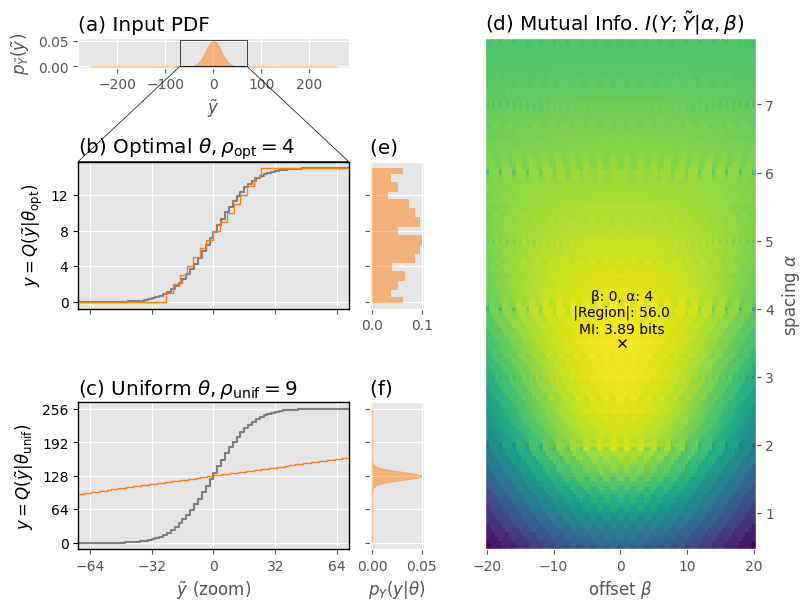

In [5]:


panels = [["a", ".", ".", "d"], ["b", "e", ".", "d"], ["c", "f", ".", "d"]]
fig, ax = plt.subplot_mosaic(
    panels,
    constrained_layout=True,
    figsize=(8, 6),
    width_ratios=[1, 0.2, 0.1, 1],
    height_ratios=[0.2, 1, 1],
    gridspec_kw={"wspace": 0.0},
)

# share axes
ax["b"].sharex(ax["c"])
# ax["e"].sharex(ax["f"])
ax["e"].sharey(ax["b"])
ax["f"].sharey(ax["c"])

# plot the input pdf
p_n = jnp.exp(d.log_prob(d.support))
ax["a"].fill_between(d.support, p_n, step="mid", alpha=0.5, color="C1")

# plot the quantization functions
_, lines = plot_quantization(
    ax["b"],
    thresholds_opt,
    dist=d,
    linecolor=f"C1",
    yticklocator=MultipleLocator(2 ** (num_bits - 2)),
    xticklocator=MultipleLocator(32),
    twinaxis=False,
)
_, lines = plot_quantization(
    ax["c"],
    thresholds_naive,
    dist=d,
    linecolor=f"C1",
    yticklocator=MultipleLocator(2 ** (8 - 2)),
    xticklocator=MultipleLocator(32),
    twinaxis=False,
)

# plot the output pdfs
yy = jnp.arange(len(thresholds_opt) - 1)
P_y = jnp.exp(log_pdf_y(d, yy, thresholds_opt[jnp.newaxis, :], noise_std=noise_std))
ax["e"].fill_betweenx(yy, P_y, step="mid", alpha=0.5, color="C1")

yy = jnp.arange(len(thresholds_naive) - 1)
P_y = jnp.exp(log_pdf_y(d, yy, thresholds_naive[jnp.newaxis, :], noise_std=noise_std))
ax["f"].fill_betweenx(yy, P_y, step="mid", alpha=0.5, color="C1")

# plot the parameter sweep
# _, im = plot_sweep(ax["d"], phases, scales, MIs.T, annotate=(max_phase, max_scale, max_MI), cmap="viridis", rasterized=True)
im = ax["d"].pcolormesh(phases.ravel(), scales.ravel(), MIs.T, cmap="viridis", rasterized=True)

# annotate optimum
ax["d"].plot(max_phase, max_scale, "kx")
ax["d"].annotate(
    f"β: {max_phase:.0f}, ⍺: {max_scale:.0f}\n |Region|: {max_width} \nMI: {max_MI:.2f} bits",
    (max_phase, max_scale),
    (0, 5),
    va="bottom",
    ha="center",
    textcoords="offset points",
    fontsize=10,
    # color="white",
)

# cosmetics

# set titles
title = {
    "a": "Input PDF",
    "b": "Optimal $\\theta, \\rho_\\text{opt}=4$",
    "c": "Uniform $\\theta, \\rho_\\text{unif}=9$",
    "d": "Mutual Info. $I(Y;\\tilde Y | \\alpha, \\beta)$",
    "e": "",
    "f": "",
}
for i, row in enumerate(panels):
    for j, panel in enumerate(row):
        if panel == ".":
            continue
        ax[panel].set_title(f"({panel}) {title[panel]}", loc="left")

# zoom into subregion
(xmin, xmax) = (-70, 70)
(ymin, ymax) = (0, p_n.max()*1.05)
ax["c"].set_xlim(xmin, xmax)
# add zoom effect from panel a to b
rect = Rectangle(
    (xmin, ymin),
    xmax - xmin,
    ymax - ymin,
    edgecolor="black",
    facecolor="none",
)
ax["a"].add_patch(rect)

c = BboxConnectorPatch(
    TransformedBbox(rect.get_bbox(), ax["a"].transData),
    ax["b"].bbox,
    clip_on=False,
    loc1a=3,
    loc1b=4,
    loc2a=2,
    loc2b=1,
    ec="black",
)

ax["b"].add_patch(c)
c.set_in_layout(False)

for panel in ["b", "c"]:
    ax[panel].set_frame_on(True)
    # ax_zoomed.patch.set_edgecolor("black")
    for spine in ax[panel].spines.values():
        # spine.set_edgecolor('black')
        plt.setp(spine, color="black")
    
# set labels
ax["a"].set_xlabel(r"$\tilde y$")
ax["c"].set_xlabel(r"$\tilde y$ (zoom)")
ax["f"].set_xlabel(r"$p_Y(y | \theta)$")
ax["a"].set_ylabel(r"$p_\tilde{Y}(\tilde y)$")
ax["b"].set_ylabel(r"$y=Q(\tilde y | \theta_\text{opt})$")
ax["c"].set_ylabel(r"$y=Q(\tilde y | \theta_\text{unif})$")
ax["d"].set_ylabel(r"spacing ${\alpha}$")
ax["d"].set_xlabel(r"offset $\beta$")

# flip the location of the y-axis of panel d
ax["d"].yaxis.tick_right()
ax["d"].yaxis.set_label_position("right")


# hide ticks for shared axes
plt.setp(ax["b"].get_xticklabels(), visible=False)
plt.setp(ax["e"].get_yticklabels(), visible=False)
# plt.setp(ax["e"].get_xticklabels(), visible=False)
plt.setp(ax["f"].get_yticklabels(), visible=False)

fig.savefig("../figures/optimum.pdf", bbox_inches="tight")
fig.savefig("../figures/optimum.svg", bbox_inches="tight")
fig.savefig("../figures/optimum.png", bbox_inches="tight", dpi=300)